# Homework 4

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [31]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [32]:
# Define a function to calculate interest rates from discount factors
def discount_to_intrate(discount, maturity, n_compound=None):

    # If the compounding frequency is not provided, assume continuous compounding
    if n_compound is None:
        # Calculate the continuously compounded interest rate
        intrate = - np.log(discount) / maturity
    else:
        # Calculate the interest rate with discrete compounding
        intrate = n_compound * (1 / discount**(1 / (n_compound * maturity)) - 1)
    
    # Return the computed interest rate
    return intrate

# Convert the Interest/Discount Rate to Discount Factor
def intrate_to_discount(intrate, maturity, n_compound=None):
    # Converts interest rates into discount factors for time value of money calculations.
    # If compounding frequency is not specified, continuous compounding is assumed.
    
    if n_compound is None:
        # Compute the discount factor using the continuous compounding formula:
        # discount = e^(-rate * maturity)
        discount = np.exp(-intrate * maturity)
    else:
        # Compute the discount factor using periodic compounding:
        # discount = 1 / (1 + rate/n_compound)^(n_compound * maturity)
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)
    
    return discount  # Return the computed discount factor.

def get_coupon_dates(quote_date, maturity_date):
    # Check if quote_date is a string; if yes, convert it to a datetime object
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    # Check if maturity_date is a string; if yes, convert it to a datetime object
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # Calculate the number of semi-annual periods between quote_date and maturity_date
    # Use ceil to ensure we cover the full period (even if partial)
    num_periods = np.ceil((maturity_date - quote_date).days / 180)
    
    # Generate semi-annual dates going backward from the maturity date
    temp = pd.date_range(
        end=maturity_date, 
        periods=num_periods, 
        freq=pd.DateOffset(months=6)
    )
    
    # Keep only the dates that are after the quote date
    temp = pd.DataFrame(data=temp[temp > quote_date])
    
    # Extract the first column of the DataFrame and return it as the result
    out = temp[0]
    return out


def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    # Initialize an empty list to store the benchmark dates
    mask_benchmark_dts = []
    
    # Loop through each column (date) in the cash flow DataFrame
    for col in CF.columns:
        # If filtering by benchmark dates is enabled
        if filter_benchmark_dates:
            # Check if the date is one of the benchmark dates (Feb 15, May 15, Aug 15, Nov 15)
            if col.month in [2, 5, 8, 11] and col.day == 15:
                mask_benchmark_dts.append(col)  # Add it to the list of benchmark dates
        else:
            # If not filtering by benchmark dates, include all dates
            mask_benchmark_dts.append(col)

    # If filtering by maturity dates is enabled
    if filter_maturity_dates:
        # Select columns where at least one cash flow >= 100 (indicating maturity)
        mask_maturity_dts = CF.columns[(CF >= 100).any()]
    else:
        # If not filtering by maturity dates, include all columns
        mask_maturity_dts = CF.columns

    # Combine the two filters: Keep only dates present in both lists
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    # Filter the cash flow DataFrame to include only the selected dates
    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # Strict filtering: Keep only rows where cash flows on included dates match the original cash flows
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]
    else:
        # Lenient filtering: Keep rows with at least one non-zero cash flow on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
    # Remove columns (dates) where all cash flows are zero
    CF_filtered = CF_filtered.loc[:, (CF_filtered > 0).any()]
    
    # Return the filtered cash flow DataFrame
    return CF_filtered


def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['quote date'].values[-1]
    
    outdata = outdata[outdata['quote date']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['maturity date'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['maturity date'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['maturity date'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['type'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['ytm']>0]
        
    return outdata


def calc_cashflows(quote_data, filter_maturity_dates=False):
    # Create an empty DataFrame to store cash flows
    # Rows represent individual securities (indexed by quote_data.index)
    # Columns represent unique maturity dates from the data
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    # Iterate over each security in the dataset
    for i in quote_data.index:
        # Get the semi-annual coupon payment dates for the security
        coupon_dates = get_coupon_dates(quote_data.loc[i, 'quote date'], quote_data.loc[i, 'maturity date'])

        # If coupon dates exist (not None), set coupon payment amounts
        if coupon_dates is not None:
            # Add semi-annual coupon payments (coupon rate divided by 2)
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2

        # Add the face value (100) at maturity
        CF.loc[i, quote_data.loc[i, 'maturity date']] += 100

    # Replace any NaN values with 0 and sort columns by date
    CF = CF.fillna(0).sort_index(axis=1)
    
    # Remove columns (dates) where all cash flows are zero
    CF.drop(columns=CF.columns[(CF == 0).all()], inplace=True)

    # If filtering by maturity dates is requested, apply the filter function
    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    # Return the final cash flow DataFrame
    return CF


def get_maturity_delta(t_maturity, t_current):
    # Calculates the time-to-maturity in years based on the difference between maturity date and current date.
    # Time is expressed as a fraction of a year (365.25 days to account for leap years).
    
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')  # Convert timedelta to years.
    
    return maturity_delta  # Return the time-to-maturity in years.

def bootstrap(params, maturity):
    # Extract estimated maturities from the first element of params
    estimated_maturities = params[0]
    # Extract corresponding discount factors (betas) from the second element of params
    betas = params[1]
    # Convert discount factors to interest rates using the discount_to_intrate function
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    # Create an interpolation function for the rates based on maturities
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    # Use the interpolation function to estimate the rate at the given maturity
    rate = f(maturity)
    
    # Return the interpolated rate
    return rate

def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    # Prices future cash flows using an interest rate model and optionally converts rates to discount factors.
    
    # Compute the time-to-maturity for all cash flow dates.
    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        # Initialize an array to store discount factors.
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            # Convert rates (from model) to discount factors using the specified model.
            disc[i] = intrate_to_discount(fun_model(params, mat), mat)
    else:
        # If no discounting is required, use rates directly from the model.
        disc = fun_model(params, maturity)
        
    if price_coupons:
        price = CF * disc
    else:
        # price = cash flow matrix multiply discount factors
        price = CF @ disc
    
    return price

def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    # Computes the difference (error) between observed market prices and model-derived prices.
    # The objective is to minimize this error during model calibration.

    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)  # Get model-derived prices.
    
    if isinstance(observed_prices, (pd.DataFrame, pd.Series)):
        # Convert observed prices to NumPy array if they are in Pandas format.
        observed_prices = observed_prices.values
    
    error = sum((observed_prices - price_modeled)**2)  # Compute the sum of squared differences.
    
    return error  # Return the sum of squared errors.

def nelson_siegel(params, maturity):
    # Nelson-Siegel model is used to fit yield curves with a combination of level, slope, and curvature components.
    # params: [beta_0, beta_1, beta_2, tau], where beta's control curve shape and tau is the decay factor.
    
    rate = (
        params[0] +  # Level component (long-term interest rate).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Weighted adjustment factor.
        params[2] * np.exp(-maturity / params[3])  # Curvature component decay.
    )
    return rate  # Return the modeled interest rate for the given maturity.

def nelson_siegel_extended(params, maturity):
    # Implements the extended Nelson-Siegel model for yield curve fitting.
    # params: A list of parameters [beta_0, beta_1, beta_2, tau_1, beta_3, tau_2]
    # - beta_0: Level parameter (long-term rate).
    # - beta_1: Slope parameter (short-term rate adjustment).
    # - beta_2: Curvature parameter (medium-term adjustment).
    # - tau_1: Decay factor for the slope and curvature components.
    # - beta_3: Second curvature parameter for additional flexibility.
    # - tau_2: Decay factor for the second curvature component.
    # maturity: Array or scalar of times to maturity (in years).

    rate = (
        params[0] +  # Long-term level component (constant for all maturities).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Slope/curvature weighted adjustment.
        params[2] * np.exp(-maturity / params[3]) +  # Exponential decay of the first curvature.
        params[4] * (  # Second curvature adjustment with separate parameters.
            (1 - np.exp(-maturity / params[5])) / (maturity / params[5]) -  # Weighted adjustment for second curvature.
            np.exp(-maturity / params[5])  # Exponential decay of the second curvature.
        )
    )
    
    return rate  # Returns the modeled interest rate for the given maturity.

def estimate_curve_ols(CF, prices, interpolate=False):
    # Estimates discount factors using linear regression (ordinary least squares).
    
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        # Ensure the alignment between cash flows and observed prices.
        prices = prices[CF.index].values
    
    # Fit a regression model where cash flows explain observed prices (no intercept).
    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)
    
    if interpolate:
        # Interpolate discount factors to obtain a smooth curve.
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())  # Maturity grid for interpolation.
        
        # Identify valid discount factors within a reasonable range.
        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)
        
        xold = matgrid[dts_valid]  # Valid maturities.
        yold = mod.coef_[dts_valid]  # Valid discount factors.
        xnew = matgrid  # Full maturity grid.
        
        # Create an interpolation function to estimate discount factors for all maturities.
        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)  # Compute interpolated discount factors.
    else:
        discounts = mod.coef_  # Use OLS coefficients directly as discount factors.
        
    return discounts  # Return discount factors (direct or interpolated).

def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    # Estimates parameters for an interest rate curve model by minimizing pricing errors.
    
    if model is bootstrap:
        # Use bootstrap method to estimate discount factors first.
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        # Calculate maturities for each cash flow.
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
        
        # Combine maturities and corresponding discount factors as model parameters.
        params_optimized = [CF_intervals, params]
    else:
        # Provide default initial guess if none is specified.
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10  # Default guess for Nelson-Siegel model parameters.
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)  # Default guess for extended model.
            else:
                x0 = 1  # Generic default initial guess.
        
        # Optimize the model parameters to minimize pricing errors.
        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x  # Extract optimized parameters.
    
    return params_optimized  # Return the estimated model parameters.


def price_treasury_ytm(yield_to_maturity, coupon_rate, face_value, time_to_maturity, payments_per_year=2):
    """
    Prices a Treasury bond based on its yield to maturity, coupon rate, face value, and time to maturity.

    Parameters:
        yield_to_maturity (float): The annual yield to maturity (as a decimal, e.g., 0.03 for 3%).
        coupon_rate (float): The annual coupon rate (as a decimal, e.g., 0.02 for 2%).
        face_value (float): The face value (par value) of the bond.
        time_to_maturity (float): The time to maturity of the bond in years.
        payments_per_year (int): The number of coupon payments per year (default is 2 for semi-annual payments).

    Returns:
        float: The price of the Treasury bond.
    """
    # Calculate the coupon payment per period
    coupon_payment = coupon_rate * face_value / payments_per_year

    # Total number of periods
    total_periods = int(time_to_maturity * payments_per_year)

    # Periodic yield to maturity
    periodic_yield = yield_to_maturity / payments_per_year

    # Price calculation: Sum of discounted coupon payments + discounted face value
    price = 0

    for t in range(1, total_periods + 1):
        price += coupon_payment / (1 + periodic_yield) ** t

    # Add the present value of the face value (paid at maturity)
    price += face_value / (1 + periodic_yield) ** total_periods

    return price

# Duration for a fixed rate bond
# freq = frequency of compounding in a year
# tau = years-to-maturity

def duration_closed_formula(tau, ytm, coupon_rate=None, freq=2):

    if coupon_rate is None:
        coupon_rate = ytm
        
    # y_tilde = ytm/frequency
    y = ytm/freq
    # c_tilde = coupon rate/ frequency
    c = coupon_rate/freq
    # tau_tilde= tau * frequency
    T = tau * freq
        
    if coupon_rate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'dirty price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['dirty price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

***

# 1 HBS Case: The Information Content of the Yield Curve

## 1.1

The Term Spread
* What is the term spread? 
* What is the preferred measure of the term spread in the case?
* What evidence is cited for the term spread's power in predicting recessions?
* Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?

Using the file `yields.xlsx`, calculate the term spread at the end of the sample.
* What does this term spread suggest about economic growth, according to the evidence of Estrella?

## 1.2

Term premia
* What is the term premium? Why is it impossible to get a direct measure of it?
* Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?

## 1.3

Though this case touches on monetary policy, that is not our focus. Rather, our focus is the degree to which the current shape of the yield curve is predictive of future short-term interest rates.

Suppose the term premium is zero. 
* What does a downward-sloping yield curve predict about future short-term rates? 
* In this case, is it risky to hold long-term bonds or short-term bonds? Is this risk compensated?

Suppose the term premium increases 5 percentage points.
* What would change about your previous answer?

In [33]:
# Specify the quote date

filepath_rawdata = f'../data/yields.xlsx'
yields = pd.read_excel(filepath_rawdata,sheet_name='yields')
yields.set_index('caldt',inplace=True)

yields.head(3)

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049


In [34]:
# Term Spread = 10Y - 1Y
yields['Term Spread'] = yields[10] - yields[1] 
yields.head()

,1,2,5,7,10,20,30,Term Spread
caldt,,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172,0.882912
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316,0.930051
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049,0.933333
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543,0.965321
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018,0.934087


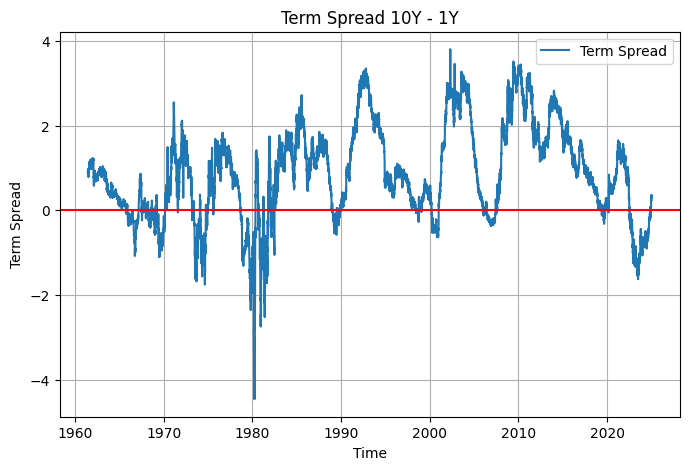

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(yields['Term Spread'], linestyle='-', label="Term Spread")
plt.axhline(0, c='r')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Term Spread")
plt.title("Term Spread 10Y - 1Y")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

***

# 2 Forward Curve from the Spot Curve

Use the data in `'../data/treasury_quotes_2024-10-31.xlsx`, focusing on the selected data found in the sheet `selected quotes`.

In [36]:
# Specify the quote date
QUOTE_DATE = '2024-10-31'

# Importing the excel file
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
quotes = pd.read_excel(filepath_rawdata,sheet_name='selected quotes').set_index('KYTREASNO')

# Rename from column name
quotes.rename(columns={'maturity date': 'maturity'}, inplace=True)
#quotes.rename(columns={'price': 'dirty price'}, inplace=True)

# Current date
t_current = quotes['quote date'].values[0]

quotes.head(3)

,type,quote date,issue date,maturity,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327


### 2.1 
Bootstrap the discount factor. 

Plot the answer in terms of discount factors and discount rates.

Though the time-to-maturity (ttm) is not spaced exactly at 6 months, for the purposes of this problem, you are welcome to approximate that they are spaced at exact 6-month intervals.




In [37]:
COMPOUNDING = 2

bootstrap_rate = bootstrap_spot_rates(quotes)
bootstrap_df = pd.DataFrame(bootstrap_rate)
bootstrap_df.index.name = 'Time to Maturity'
bootstrap_df.columns = ['Bootstrap Rate']
bootstrap_df

,Bootstrap Rate
Time to Maturity,
0.495551,0.044529
0.999316,0.043277
1.494867,0.042180
1.998631,0.041579
2.494182,0.041249
2.997947,0.041236
3.496235,0.041440
4.000000,0.041617
4.495551,0.041546


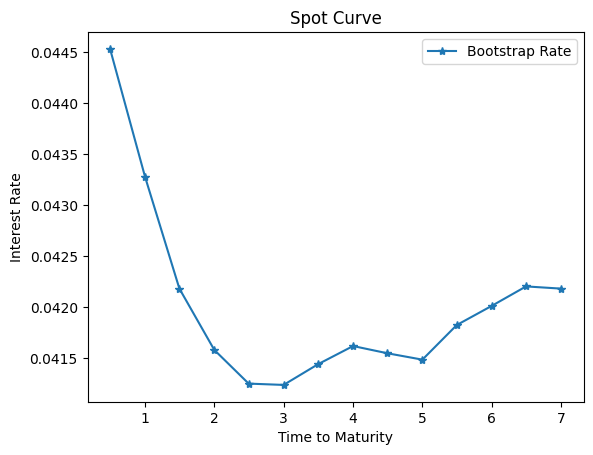

In [38]:
ax = bootstrap_df.plot(marker = '*', linestyle='-')

# For legends, the names of the columns from the dataframes
plt.legend(bootstrap_df)

plt.xlabel('Time to Maturity')
plt.ylabel('Interest Rate')
plt.title('Spot Curve')
plt.show()

In [39]:
TTM = bootstrap_df.index.values
TTM

array([0.49555099, 0.99931554, 1.49486653, 1.99863107, 2.49418207,
       2.99794661, 3.49623546, 4.        , 4.49555099, 4.99931554,
       5.49486653, 5.99863107, 6.49418207, 6.99794661])

In [40]:
intrate = bootstrap_rate
maturity = TTM
bs_disc_factor = intrate_to_discount(intrate, maturity, n_compound=2)
bootstrap_df['Bootstrap Discount Factor'] = bs_disc_factor
bootstrap_df

,Bootstrap Rate,Bootstrap Discount Factor
Time to Maturity,,
0.495551,0.044529,0.978412
0.999316,0.043277,0.958116
1.494867,0.042180,0.939509
1.998631,0.041579,0.921043
2.494182,0.041249,0.903178
2.997947,0.041236,0.884824
3.496235,0.041440,0.866405
4.000000,0.041617,0.848097
4.495551,0.041546,0.831221


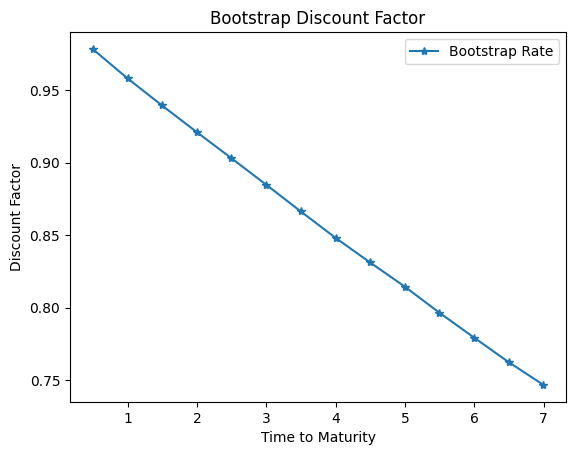

In [41]:
ax = bootstrap_df['Bootstrap Discount Factor'].plot(marker = '*', linestyle='-')

plt.legend(bootstrap_df)

plt.xlabel('Time to Maturity')
plt.ylabel('Discount Factor')
plt.title('Bootstrap Discount Factor')
plt.show()

### 2.2
Calculate and plot the forward discount factors from $T$ to $T+0.5$, ranging $T$ from 0.5 through 6.5.




In [49]:
# Computing the Forward Rate
forward_disc_factor = bootstrap_df['Bootstrap Discount Factor'] / bootstrap_df['Bootstrap Discount Factor'].shift(1)

# Put it on the dataframe
bootstrap_df['Forward Discount Factor'] = forward_disc_factor

# Put the first value as the same as the bootstrap DF
bootstrap_df['Forward Discount Factor'].iloc[0] = bootstrap_df['Bootstrap Discount Factor'].iloc[0]

bootstrap_df.head()

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_74031/2148024143.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bootstrap_df['Forward Discount Factor'].iloc[0] = bootstrap_df['Bootstrap Discount Factor'].iloc[0]


,Bootstrap Rate,Bootstrap Discount Factor,Forward Discount Factor
T,,,
0.495551,0.044529,0.978412,0.978412
0.999316,0.043277,0.958116,0.979257
1.494867,0.042180,0.939509,0.980579
1.998631,0.041579,0.921043,0.980345
2.494182,0.041249,0.903178,0.980604


In [56]:
# Create a new DataFrame with only the 'Forward Disc Factor' column
forward_df = bootstrap_df[['Forward Discount Factor']]

# Rename the index to 'T'
forward_df.index.name = "T"

forward_df

,Forward Discount Factor
T,
0.495551,0.978412
0.999316,0.979257
1.494867,0.980579
1.998631,0.980345
2.494182,0.980604
2.997947,0.979679
3.496235,0.979184
4.000000,0.978869
4.495551,0.980102


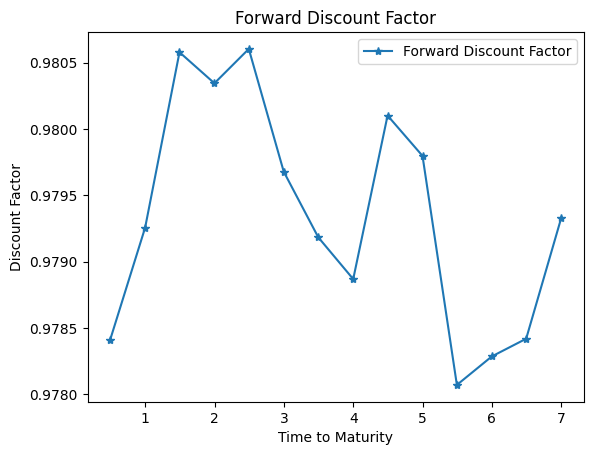

In [69]:
ax = forward_df['Forward Discount Factor'].plot(marker = '*', linestyle='-')

plt.legend(forward_df)

plt.xlabel('Time to Maturity')
plt.ylabel('Discount Factor')
plt.title('Forward Discount Factor')
plt.show()

### 2.3
Use the forward discount factors to calculate the `semiannually` compounded forward **rates**.

Plot the curve.

In [75]:
forward_df.index.to_series().diff().mean()

np.float64(0.5001842784183647)

In [70]:
# Computing the Forward Rate
forward_rate = -np.log(forward_df['Forward Discount Factor']) / forward_df.index.to_series().diff().mean()
forward_df['Forward Rate'] = forward_rate
forward_df

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_74031/16050181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['Forward Rate'] = forward_rate


,Forward Discount Factor,Forward Rate
T,,
0.495551,0.978412,0.043632
0.999316,0.979257,0.041908
1.494867,0.980579,0.039210
1.998631,0.980345,0.039687
2.494182,0.980604,0.039159
2.997947,0.979679,0.041046
3.496235,0.979184,0.042057
4.000000,0.978869,0.042700
4.495551,0.980102,0.040183


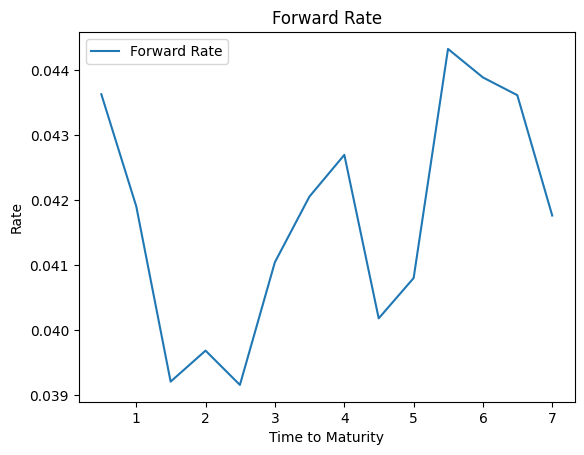

In [78]:
ax = forward_df['Forward Rate'].plot(linestyle='-')

plt.legend()
plt.xlabel('Time to Maturity')
plt.ylabel('Rate')
plt.title('Forward Rate')
plt.show()

In [76]:
# Convert continuous compounding rate to semi-annual compounding rate
forward_semi_annual = 2 * (np.exp(forward_rate / 2) - 1)  
forward_df['Forward Rate Semi-Annual'] = forward_semi_annual
forward_df.head()

,Forward Discount Factor,Forward Rate,Forward Rate Semi-Annual
T,,,
0.495551,0.978412,0.043632,0.044112
0.999316,0.979257,0.041908,0.042350
1.494867,0.980579,0.039210,0.039597
1.998631,0.980345,0.039687,0.040083
2.494182,0.980604,0.039159,0.039545


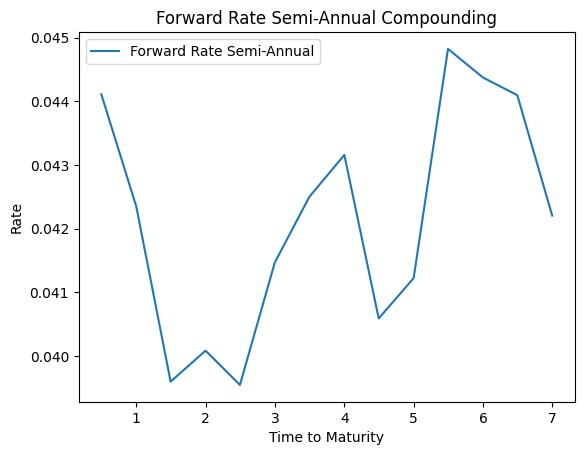

In [80]:
ax = forward_df['Forward Rate Semi-Annual'] .plot(linestyle='-')

plt.legend()
plt.xlabel('Time to Maturity')
plt.ylabel('Rate')
plt.title('Forward Rate Semi-Annual Compounding')
plt.show()

#### 2.4

Specifically report the forward-rate values from 

* $T_1=0.5$ to $T_2=1$.
* $T_1=3.5$ to $T_2=4$.

In [81]:
forward_df

,Forward Discount Factor,Forward Rate,Forward Rate Semi-Annual
T,,,
0.495551,0.978412,0.043632,0.044112
0.999316,0.979257,0.041908,0.042350
1.494867,0.980579,0.039210,0.039597
1.998631,0.980345,0.039687,0.040083
2.494182,0.980604,0.039159,0.039545
2.997947,0.979679,0.041046,0.041470
3.496235,0.979184,0.042057,0.042502
4.000000,0.978869,0.042700,0.043159
4.495551,0.980102,0.040183,0.040590


In [87]:
# Retrieve the Forward Rates, use position for T2
forward_rate_value = forward_df.iloc[1]['Forward Rate'] * 100
print(f'The Forward Rate from T1 = 0.5 to T2 = 1 is {forward_rate_value:.2f}%')

# Retrieve the Forward Rates, use position for T2
forward_rate_value = forward_df.iloc[7]['Forward Rate'] * 100
print(f'The Forward Rate from T1 = 3.5 to T2 = 4 is {forward_rate_value:.2f}%')

The Forward Rate from T1 = 0.5 to T2 = 1 is 4.19%
The Forward Rate from T1 = 3.5 to T2 = 4 is 4.27%


***

# 3. Forward Discount Factors, Forward Rates, and Evolving Spot Rates

Use the data set `famabliss_strips_2024-12-31.xlsx`.

It gives prices on **zero coupon bonds** with maturities of 1 through 5 years.
* These are prices per $1 face value on bonds that only pay principal.
* Such bonds can be created from treasuries by stripping out their coupons.
* In essence, you can consider these prices as the discount factors $Z$, for maturity intervals 1 through 5 years.

In this problem, we focus on six dates: the month of `December` in `2020` through `2024`.

In [88]:
# Specify the quote date
QUOTE_DATE = '2024-12-31'

# Importing the excel file
filepath_rawdata = f'../data/famabliss_strips_{QUOTE_DATE}.xlsx'
prices = pd.read_excel(filepath_rawdata,sheet_name='prices')
prices.set_index('date',inplace=True)

# Convert index to datetime if not already
prices.index = pd.to_datetime(prices.index)

# Filter for rows where the month is December and the year is between 2020 and 2024
filtered_px = prices[(prices.index.month == 12) & (prices.index.year >= 2020) & (prices.index.year <= 2024)]

# Display the filtered DataFrame
filtered_px

,1,2,3,4,5
date,,,,,
2020-12-31,0.998959,0.997520,0.995299,0.989455,0.981537
2021-12-31,0.996173,0.985500,0.971251,0.954872,0.938668
2022-12-30,0.954636,0.916229,0.883347,0.851046,0.820298
2023-12-29,0.953787,0.919644,0.888523,0.856672,0.826740
2024-12-31,0.959864,0.919585,0.880687,0.841768,0.804591


### 3.1

For each of the dates, (`Dec 2020`, ..., `Dec 2024`), calculate the forward discount factor, $F(t,T_1,T_2)$, where $T_2 = T_1 + 1$ for $1\le T_1\le 4$.

Make a plot of the curve $F$ at each of these six dates.

In [89]:
# Calculating the discount rate
discount = filtered_px
maturity = filtered_px.columns
# Use continuous compounding
spot_rate = discount_to_intrate(discount, maturity, n_compound=None)
spot_rate

,1,2,3,4,5
date,,,,,
2020-12-31,0.001042,0.001242,0.001571,0.00265,0.003727
2021-12-31,0.003834,0.007303,0.009724,0.011545,0.012659
2022-12-30,0.046425,0.043744,0.041346,0.040322,0.039618
2023-12-29,0.047314,0.041884,0.039398,0.038675,0.038053
2024-12-31,0.040964,0.041916,0.042351,0.043063,0.043484


In [90]:
# Computing the Forward Rate where T1 = 1
forward_disc_factor = filtered_px[[2,3,4,5]] / filtered_px[[1,2,3,4]].values
forward_disc_factor

,2,3,4,5
date,,,,
2020-12-31,0.998560,0.997773,0.994129,0.991997
2021-12-31,0.989286,0.985541,0.983136,0.983031
2022-12-30,0.959768,0.964111,0.963434,0.963870
2023-12-29,0.964203,0.966159,0.964153,0.965059
2024-12-31,0.958037,0.957701,0.955808,0.955836


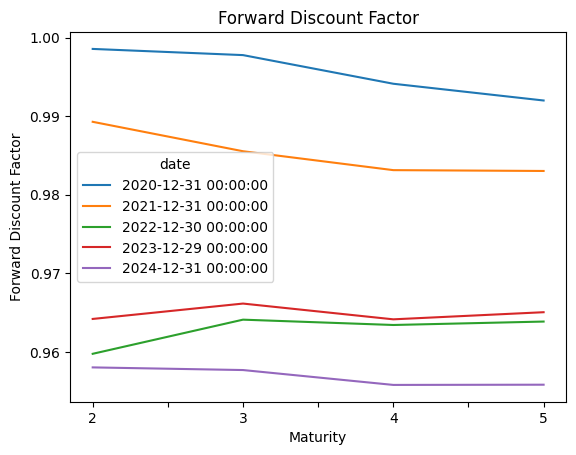

In [91]:
ax = forward_disc_factor.T.plot(linestyle='-',ylabel='Forward Discount Factor',xlabel='Maturity',title='Forward Discount Factor')
plt.show()

### 3.2



Use $F$ above to calculate the continuously compounded forward rates, $f$, on each date.

Make a plot of the curve, $f$, at each of these dates.

In [98]:
forward_rate = -np.log(forward_disc_factor)
forward_rate.head()

,2,3,4,5
date,,,,
2020-12-31,0.001441,0.002229,0.005889,0.008035
2021-12-31,0.010772,0.014564,0.017008,0.017115
2022-12-30,0.041064,0.036548,0.037252,0.036799
2023-12-29,0.036454,0.034427,0.036505,0.035566
2024-12-31,0.042869,0.043220,0.045199,0.045169


In [99]:
# Concatenate spot rate (year 1) with forward_rate
forward_rate = pd.concat([spot_rate[1], forward_rate], axis=1)

# Display the updated DataFrame
forward_rate


,1,2,3,4,5
date,,,,,
2020-12-31,0.001042,0.001441,0.002229,0.005889,0.008035
2021-12-31,0.003834,0.010772,0.014564,0.017008,0.017115
2022-12-30,0.046425,0.041064,0.036548,0.037252,0.036799
2023-12-29,0.047314,0.036454,0.034427,0.036505,0.035566
2024-12-31,0.040964,0.042869,0.043220,0.045199,0.045169


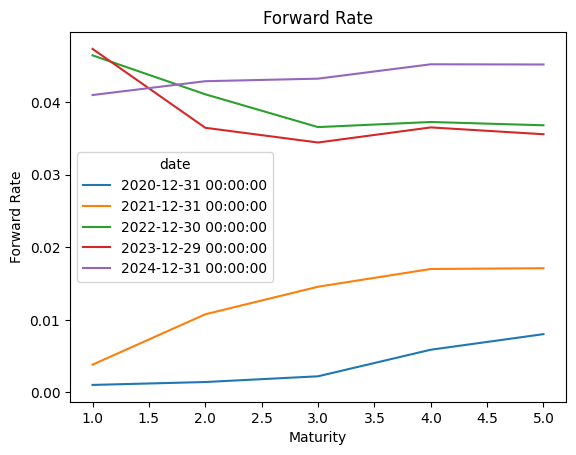

In [101]:
ax = forward_rate.T.plot(linestyle='-',ylabel='Forward Rate',xlabel='Maturity',title='Forward Rate')
plt.show()

### 3.3

Calculate the continuously compounded spot rates, $r$, at these dates.

Plot both the forward curve and the spot curve on the date of `Dec 2020`.

Recall that $f(t,t,t+1) = r(t,t+1)$.

In [102]:
# Calculating the discount rate
discount = filtered_px
maturity = filtered_px.columns
# Use continuous compounding
spot_rate = discount_to_intrate(discount, maturity, n_compound=None)
spot_rate

,1,2,3,4,5
date,,,,,
2020-12-31,0.001042,0.001242,0.001571,0.00265,0.003727
2021-12-31,0.003834,0.007303,0.009724,0.011545,0.012659
2022-12-30,0.046425,0.043744,0.041346,0.040322,0.039618
2023-12-29,0.047314,0.041884,0.039398,0.038675,0.038053
2024-12-31,0.040964,0.041916,0.042351,0.043063,0.043484


In [103]:
# Select only the row for '2020-12-31' and transpose
spot_rate_dec2020 = spot_rate.loc[['2020-12-31']].T

# Rename the column to 'Spot'
spot_rate_dec2020 = spot_rate_dec2020.rename(columns={spot_rate_dec2020.columns[0]: 'Spot'})

# Display the updated DataFrame
display(spot_rate_dec2020)


date,Spot
1,0.001042
2,0.001242
3,0.001571
4,0.00265
5,0.003727


In [104]:
# Select only the row for '2020-12-31' and transpose
forward_rate_dec2020 = forward_rate.loc[['2020-12-31']].T

# Rename the column to 'Spot'
forward_rate_dec2020 = forward_rate_dec2020.rename(columns={forward_rate_dec2020.columns[0]: 'Forward'})

# Display the updated DataFrame
display(forward_rate_dec2020)


date,Forward
1,0.001042
2,0.001441
3,0.002229
4,0.005889
5,0.008035


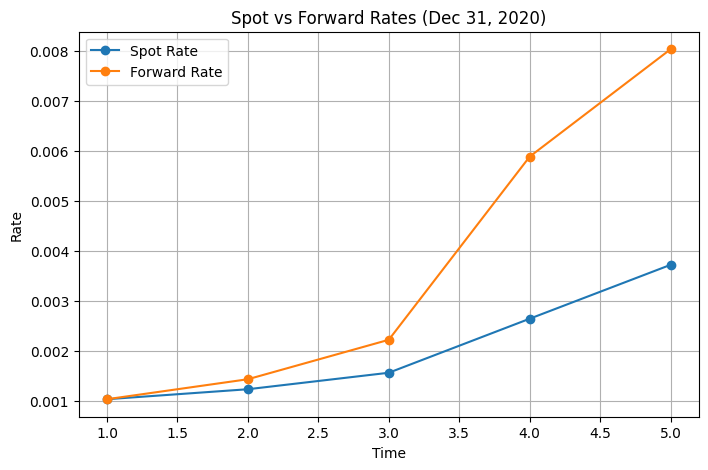

In [105]:
# Plot Spot and Forward Rates
plt.figure(figsize=(8, 5))
plt.plot(spot_rate_dec2020, marker='o', linestyle='-', label="Spot Rate")
plt.plot(forward_rate_dec2020, marker='o', linestyle='-', label="Forward Rate")

# Labels and title
plt.xlabel("Time")
plt.ylabel("Rate")
plt.title("Spot vs Forward Rates (Dec 31, 2020)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### 3.4

Plot the forward curve on `Dec 2020` against the time-series evolution of $r(t,t+1)$ for dates $t$ between `Dec 2020` and `Dec 2024`.

How does the evolution of one-year rates between `2020-2024` compare to the forward rates of `2020`?

In [118]:
spot_rate_evolution = spot_rate[[1]]

# Rename the column to 'Spot'
#spot_rate_evolution = spot_rate_evolution.rename(columns={spot_rate_evolution.columns[0]: 'One-Year Rates'})

# Rename the index to 1, 2, 3, 4, 5
#spot_rate_evolution.index = [1, 2, 3, 4, 5]

# Display the updated DataFrame
display(spot_rate_evolution)

,1
date,
2020-12-31,0.001042
2021-12-31,0.003834
2022-12-30,0.046425
2023-12-29,0.047314
2024-12-31,0.040964


In [121]:
spot_rate_evolution = spot_rate[[1]]

# Rename the column
spot_rate_evolution = spot_rate_evolution.rename(columns={spot_rate_evolution.columns[0]: 'One-Year Rates'})

# Rename the index to 1, 2, 3, 4, 5
spot_rate_evolution.index = [1, 2, 3, 4, 5]

# Display the updated DataFrame
display(spot_rate_evolution)

,One-Year Rates
1,0.001042
2,0.003834
3,0.046425
4,0.047314
5,0.040964


In [120]:
# Select only the row for '2020-12-31' and transpose
forward_rate_dec2020 = forward_rate.loc[['2020-12-31']].T

# Rename the column to 'Spot'
forward_rate_dec2020 = forward_rate_dec2020.rename(columns={forward_rate_dec2020.columns[0]: 'Forward'})

# Display the updated DataFrame
display(forward_rate_dec2020)


date,Forward
1,0.001042
2,0.001441
3,0.002229
4,0.005889
5,0.008035


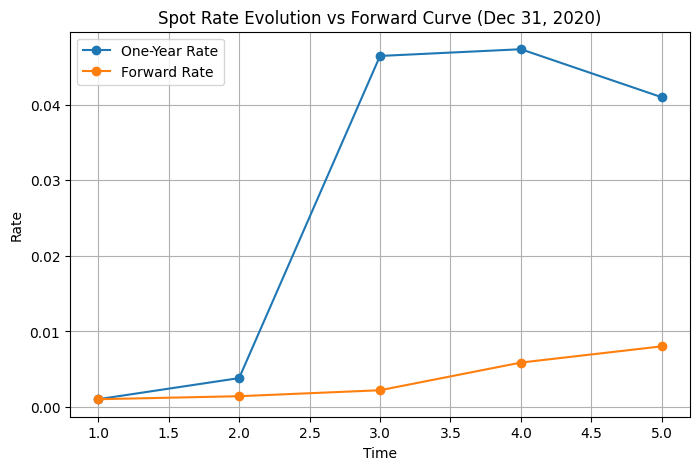

In [122]:
# Plot Spot and Forward Rates
plt.figure(figsize=(8, 5))
plt.plot(spot_rate_evolution, marker='o', linestyle='-', label="One-Year Rate")
plt.plot(forward_rate_dec2020, marker='o', linestyle='-', label="Forward Rate")

# Labels and title
plt.xlabel("Time")
plt.ylabel("Rate")
plt.title("Spot Rate Evolution vs Forward Curve (Dec 31, 2020)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### How does the evolution of one-year rates between `2020-2024` compare to the forward rates of `2020`?

All of the realized one-year spot rates are higher than what was implied by the 2020 forward curve.


***